In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm

Xtr = np.array(pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072)))
Xte = np.array(pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072)))
Ytr = np.array(pd.read_csv('data/Ytr.csv',sep=',',usecols=[1])).squeeze()


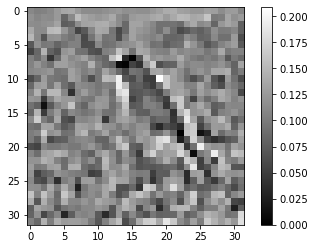

In [14]:
# convert the RGB images into grayscale?
def rgb2gray(image, gamma=1.):

    r, g, b = image[:, :1024], image[:, 1024:2048], image[:,2048:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     gray[gray<0] = 0
    gray += abs(np.min(gray, axis=1)[:, None])
#     gray = np.maximum(r, g, b)
    return gray**gamma

def normalize(image):
    m = np.mean(image, axis=1)
    sd2 = np.mean((image-m[:,None])**2, axis=1)
    return (image - m[:, None]) / np.sqrt(sd2[:, None])
x = rgb2gray(Xtr, 1.)
# print(x)
plt.imshow(x[900].reshape(32, 32), cmap='gray')
plt.colorbar()
plt.show()
# x = normalize(xx)
# plt.imshow(x[119].reshape(32, 32), cmap='gray')
# plt.colorbar()
# plt.show()


In [274]:
# descriptor length ?
x_pixel = 32
y_pixel = 32

# 1 block = 4 cells
cell_w = 2

cell_x = int(x_pixel / cell_w)  
cell_y = int(y_pixel / cell_w)

max_h = 32
max_w = 32


def image_grad(image_array):

    grad = np.zeros([max_h, max_w])
    mag = np.zeros([max_h, max_w])
    for h,row in enumerate(image_array):
        for w, val in enumerate(row):
            if h-1>=0 and w-1>=0 and h+1<max_h and w+1<max_w:
                dy = image_array[h+1][w]-image_array[h-1][w]
                dx = row[w+1]-row[w-1]+0.0001
                grad[h][w] = np.arctan(dy/dx)*(180/np.pi)
                if grad[h][w]<0:
                    grad[h][w] += 180
                mag[h][w] = np.sqrt(dy*dy+dx*dx)
    
    return grad, mag


def div_cells(mag):
    mag_cells = np.zeros(shape=(cell_x, cell_y, cell_w, cell_w)) 
    mag_x = np.split(mag, cell_x, axis=0)

    for i, l in enumerate(mag_x):
        mag_x[i] = np.array(l)
        mag_xy = np.split(mag_x[i], cell_y, axis=1)
        for j, l1 in enumerate(mag_xy):
            mag_xy[j] = np.array(l1)
            mag_cells[i][j] = mag_xy[j]

    return mag_cells


def get_bins(mag_cell, ang_cell):
    bin_num = 9
    bins = [0.0] * bin_num  
    offset = 20

    mag_list = mag_cell.flatten()
    ang_list = ang_cell.flatten()

    for i, ang in enumerate(ang_list):
        if ang >= 180:
            ang -= 180  

        left_bin = int(ang / offset)

        right_bin = left_bin + 1 if left_bin != bin_num - 1 else 0

        right_ratio = ang / offset - left_bin
        left_ration = 1 - right_ratio

        bins[left_bin] = mag_list[i] * left_ration
        bins[right_bin] = mag_list[i] * right_ratio

    return bins


def hog(img):
    ang, mag = image_grad(img)
   
    mag_cells = div_cells(mag)
    ang_cells = div_cells(ang)
    hog_descriptor = np.array([])

    for x in range(cell_x - 1):  
        for y in range(cell_y - 1):  
            hist = []
            hist.extend(get_bins(mag_cells[x][y], ang_cells[x][y]))
            hist.extend(get_bins(mag_cells[x][y + 1], ang_cells[x][y + 1]))
            hist.extend(get_bins(mag_cells[x + 1][y], ang_cells[x + 1][y])) 
            hist.extend(get_bins(mag_cells[x + 1][y + 1], ang_cells[x + 1][y + 1]))
            arr = np.array(hist)
            arr /= (np.linalg.norm(arr) + 1e-4)
            hog_descriptor = np.hstack((hog_descriptor, arr))
    return hog_descriptor


In [276]:
train_set = np.zeros((Xtr.shape[0], 8100))
for i, image in enumerate(x):
    tmp = hog(image.reshape(32, 32))
    train_set[i] = tmp

In [277]:
X_train, X_test, y_train, y_test = train_test_split(train_set, Ytr, test_size=0.2, random_state=20)
list = [1., 3., 5., 10., 100.]
for c in list:
    clf = svm.SVC(C=c, kernel='rbf')
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

0.439
0.443
0.443
0.443
0.443


In [176]:
# no feature extraction 
X_train, X_test, y_train, y_test = train_test_split(Xtr, Ytr, test_size=0.2, random_state=20)
clf = svm.SVC(C=1., kernel='rbf')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.235


In [ ]:
# predict on the test data
# for instance, Yte = classifier.fit(Xte)

# Yte = {'Prediction' : Yte}
# dataframe = pd.DataFrame(Yte)
# dataframe.index += 1
# dataframe.to_csv('Yte_pred.csv',index_label='Id')